In [111]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b
from statistics import variance
import math

In [112]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,1,1)

In [174]:
market = Market()
strats = ["dividends","earnings","fin","ratios","sector"]

In [154]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [157]:
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
bench["day"] = [x.weekday() for x in bench["date"]]
bench_returns = bench[bench["day"]==0]
bench_returns[f"bench_return"] = (bench_returns["adjclose"].shift(-4) - bench_returns["adjclose"].shift(-1)) / bench_returns["adjclose"].shift(-1)
bench_returns["variance"] = bench_returns["bench_return"].rolling(window=100).var()
bench_returns

,date,open,high,low,close,adjclose,volume,year,quarter,week,day,bench_return,variance
0,1993-01-25,43.968750,43.968750,43.750000,43.937500,25.122337,1003200,1993,1,4,0,-0.012510,NaN
1,1993-02-01,43.968750,45.093750,43.968750,44.968750,25.711994,2234800,1993,1,5,0,0.003504,NaN
2,1993-02-08,44.968750,45.125000,44.531250,44.593750,25.497580,1159800,1993,1,6,0,0.035150,NaN
3,1993-02-15,44.468750,44.468750,42.812500,43.562500,24.907940,998700,1993,1,7,0,0.014074,NaN
4,1993-02-22,43.687500,44.437500,43.468750,44.406250,25.390348,1024300,1993,1,8,0,0.008230,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,2023-04-24,411.989990,415.940002,403.779999,415.929993,415.929993,424849800,2023,2,17,0,0.014929,0.001815
1579,2023-05-01,415.470001,417.619995,403.739990,412.630005,412.630005,440398500,2023,2,18,0,NaN,NaN
1580,2023-05-08,412.970001,414.540009,408.869995,411.589996,411.589996,336006300,2023,2,19,0,NaN,NaN
1581,2023-05-15,412.220001,420.720001,410.230011,418.619995,418.619995,400138800,2023,2,20,0,NaN,NaN


In [158]:
tyields = pd.read_csv("./csv_files/FED/DGS1.csv")
tyields = p.column_date_processing(tyields)
tyields["dgs1"] = tyields["dgs1"].replace(".",0)
tyields["dgs1"] = tyields["dgs1"].astype("float")
tyields["yield"] = [1+(x/100) for x in tyields["dgs1"]]
tyields["weekly_yield"] = [math.exp(math.log(x)/52) for x in tyields["yield"]]
tyields = tyields[(tyields["year"]>=2020) & (tyields["year"]<2023)].groupby("year").mean().cumprod()
tyields

,dgs1,quarter,week,yield,weekly_yield
year,,,,,
2020,0.354580,2.507634,27.099237,1.003546,1.000068
2021,0.035458,6.302711,720.881226,1.004549,1.000087
2022,0.094963,15.805260,19103.35249,1.031453,1.000594


In [176]:
trades = []
for strat in strats:
    speculation_db = ADatabase(f"{strat}_spec")
    speculation_db.connect()
    stuff = speculation_db.retrieve("trades")
    stuff["strat"] = strat
    trades.append(stuff)
    speculation_db.disconnect()
t = pd.concat(trades)

In [177]:
reqs = [0.05]
signals = [0.05]
values = [True]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [False]
parameters = []
positions = 10
training_year = 4
for strat in strats:
    for value in values:
        for classification in classifications:
            for ceiling in ceilings:
                for floor in floors:
                    for hedge in hedges:
                        for signal in signals:
                            for req in reqs:
                                parameter = {"value":value
                                             ,"classification":classification
                                             ,"ceiling":ceiling
                                             ,"floor":floor
                                             ,"hedge":hedge
                                             ,"signal":signal
                                             ,"req":req
                                             ,"training_years":training_year
                                            ,"strat":strat
                                            }
                                parameters.append(parameter)

In [178]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        if ledger.index.size > 0:
            portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
            counted_columns = [x for x in range(positions)]
            cumulative = portfolio[[i for i in counted_columns]].cumprod()
            cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
            cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
            cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
            cumulative = cumulative.merge(bench_returns[["date","adjclose","bench_return","variance"]],on="date",how="left")
            cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
            cumulative["return"] = cumulative["pv"].pct_change().fillna(1)
            cumulative["beta"] = cumulative[["return","bench_return"]].cov().iloc[0][1]/cumulative["variance"].iloc[-1]
            cumulative["rrr"] = tyields["yield"].iloc[-1] + cumulative["beta"].iloc[-1]*(cumulative["bench"].iloc[-1]-tyields["yield"].iloc[-1])
            cumulative["sharpe"] = (cumulative["pv"] - tyields["yield"].iloc[-1]) / cumulative["beta"].iloc[-1]
            for index_stuff in indexer:
                cumulative[index_stuff] = parameter[index_stuff]
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [179]:
a

,value,classification,ceiling,floor,hedge,signal,req,training_years,strat,pv,beta,rrr,sharpe
137,True,False,True,True,False,0.05,0.05,4,dividends,1.153729,-0.033812,1.024631,-3.616299
137,True,False,True,False,False,0.05,0.05,4,dividends,0.808582,-0.082010,1.014906,2.717618
137,True,False,False,True,False,0.05,0.05,4,dividends,1.293795,-0.053824,1.020593,-4.874058
137,True,False,False,False,False,0.05,0.05,4,dividends,0.913399,-0.115277,1.008194,1.024085
137,True,False,True,True,False,0.05,0.05,4,earnings,1.579870,-0.019378,1.027543,-28.300832
137,True,False,True,False,False,0.05,0.05,4,earnings,1.162982,-0.034452,1.024502,-3.817716
137,True,False,False,True,False,0.05,0.05,4,earnings,1.694581,-0.019219,1.027575,-34.503685
137,True,False,False,False,False,0.05,0.05,4,earnings,1.046245,-0.115101,1.008229,-0.128512
137,True,False,True,True,False,0.05,0.05,4,fin,1.229501,-0.072690,1.016787,-2.724556
137,True,False,True,False,False,0.05,0.05,4,fin,1.011916,-0.060014,1.019344,0.325535


In [200]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
3,ratios,True,False,False,True,False,0.05,0.05,4,0.826890,-0.109797,0.986610,1.863105
0,dividends,True,False,False,True,False,0.05,0.05,4,1.293795,-0.053824,1.020593,-4.874058
4,sector,True,False,False,True,False,0.05,0.05,4,1.446897,-0.013412,1.028747,-30.975129
2,fin,True,False,False,True,False,0.05,0.05,4,1.514004,-0.086967,1.013906,-5.548656
1,earnings,True,False,False,True,False,0.05,0.05,4,1.694581,-0.019219,1.027575,-34.503685


In [181]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")

In [182]:
ledger.sort_values(["year","week","delta"]).head(30)

,year,week,ticker,delta,actual_returns,position,GICS Sector
1236,2020.0,2.0,LUV,0.036256,0.993553,9,Industrials
1101,2020.0,2.0,CHRW,0.036405,1.022983,8,Industrials
964,2020.0,2.0,KLAC,0.038481,0.980560,7,Information Technology
827,2020.0,2.0,GM,0.041939,0.985775,6,Consumer Discretionary
690,2020.0,2.0,MPC,0.045472,1.018262,5,Energy
552,2020.0,2.0,CE,0.045537,0.991610,4,Materials
414,2020.0,2.0,FAST,0.047245,1.011133,3,Industrials
276,2020.0,2.0,APTV,0.050787,0.981577,2,Consumer Discretionary
138,2020.0,2.0,PKG,0.066062,1.007916,1,Materials
0,2020.0,2.0,AZO,0.081196,1.011490,0,Consumer Discretionary


In [183]:
ledger

,year,week,ticker,delta,actual_returns,position,GICS Sector
0,2020.0,2.0,AZO,0.081196,1.011490,0,Consumer Discretionary
1,2020.0,3.0,AZO,0.069696,0.984181,0,Consumer Discretionary
2,2020.0,5.0,VFC,0.148103,0.992108,0,Consumer Discretionary
3,2020.0,6.0,DVN,0.140066,1.050778,0,Energy
4,2020.0,7.0,PENN,0.143842,0.998370,0,Consumer Discretionary
...,...,...,...,...,...,...,...
1366,2022.0,47.0,BDX,0.034744,0.992657,9,Health Care
1367,2022.0,48.0,WST,0.029472,1.093289,9,Health Care
1368,2022.0,49.0,CMG,0.040666,0.988160,9,Consumer Discretionary
1369,2022.0,50.0,AMGN,0.031317,0.982186,9,Health Care


In [184]:
metric = "position"

In [185]:
portfolio = ledger.pivot_table(index=["year","week"],columns=metric,values="actual_returns").fillna(1).reset_index()

In [186]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,1.011490,1.007916,0.981577,1.011133,0.991610,1.018262,0.985775,0.980560,1.022983,0.993553,2020-W2,2020-01-06,1.000486,309.315186,1.000000
1,0.995489,1.036452,1.009061,0.964022,1.020309,1.065576,1.008421,0.986648,1.045907,1.014552,2020-W3,2020-01-13,1.014644,315.241119,1.019158
2,0.987632,1.052999,0.959329,0.921701,0.987084,1.097183,0.975974,0.937315,1.004046,0.996833,2020-W5,2020-01-27,0.992010,305.535492,0.987780
3,1.037782,1.020123,0.953142,0.898679,1.006038,1.108608,0.990660,0.965215,0.992205,1.008536,2020-W6,2020-02-03,0.998099,315.478546,1.019926
4,1.036091,1.011810,0.954260,0.898165,1.017309,1.098877,0.995897,0.975297,1.000577,1.085051,2020-W7,2020-02-10,1.007333,320.606689,1.036505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1.809329,2.179017,1.427113,0.982507,2.906485,1.803810,1.161032,1.332528,2.037203,1.078436,2022-W47,2022-11-21,1.671746,398.968262,1.289844
134,1.820329,2.217470,1.465113,0.954021,3.043193,1.713620,1.122030,1.427632,2.111540,1.179042,2022-W48,2022-11-28,1.705399,403.510010,1.304527
135,1.818899,2.234115,1.470777,0.949936,3.116463,1.758046,1.129536,1.360119,2.084961,1.165081,2022-W49,2022-12-05,1.708793,389.993896,1.260830
136,1.727954,2.221971,1.552669,0.902439,3.013107,1.726556,1.159977,1.434744,2.064401,1.144327,2022-W50,2022-12-12,1.694815,380.067535,1.228739


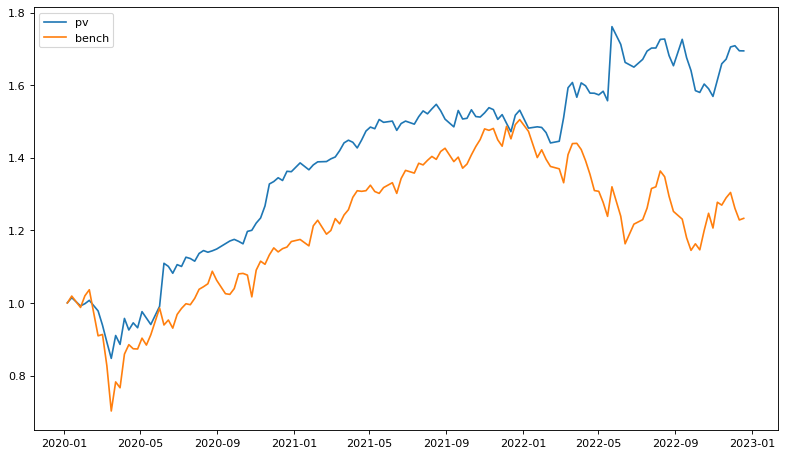

In [187]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

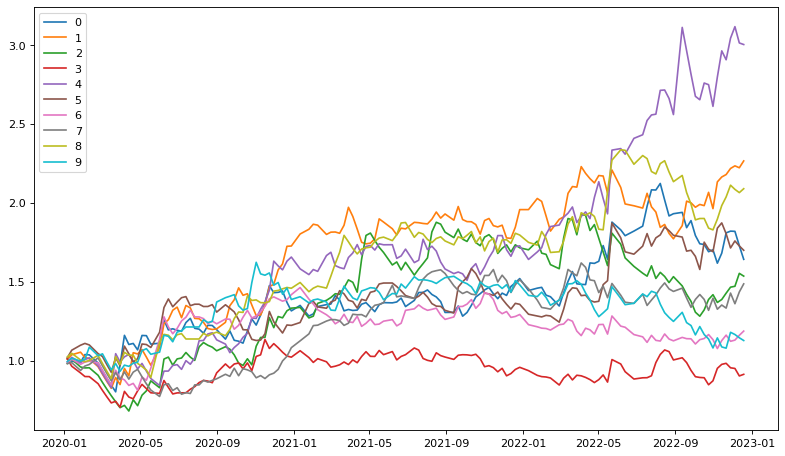

In [188]:
plt.figure(figsize=(12, 7), dpi=80)
for i in counted_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
    plt.legend(counted_columns)
plt.show()


In [189]:
ledger.groupby(["GICS Sector"]).mean().sort_values("delta",ascending=False)

,year,week,delta,actual_returns,position
GICS Sector,,,,,
Energy,2020.297030,30.475248,0.178254,1.009150,3.752475
Financials,2020.794872,30.307692,0.104237,1.000028,5.000000
Consumer Discretionary,2021.110429,26.284254,0.101660,1.003813,3.887526
Real Estate,2020.636364,29.840909,0.090799,1.014622,5.318182
Industrials,2020.781250,27.031250,0.079859,1.007676,5.250000
Communication Services,2020.950820,32.016393,0.071085,1.004673,5.065574
Information Technology,2020.934783,28.445652,0.068069,1.004269,4.250000
Consumer Staples,2020.970588,23.852941,0.067400,1.000541,5.617647
Materials,2020.888889,27.740741,0.066265,1.000443,5.271605


In [190]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2.020000e+03,2.000000e+00,1.000000,0.992947,1.000000,1.018262,1.000000,1.000000,1.009223,0.980560,0.999763,1.000000,1.000000
1,4.080400e+06,6.000000e+00,1.000000,1.005777,1.000000,1.018262,1.000000,1.006208,1.009223,0.980560,1.022449,1.000000,1.000000
2,8.242408e+09,3.000000e+01,1.000000,0.975820,1.000000,1.011013,1.000000,0.988635,0.958762,0.980560,1.010149,0.967436,1.000000
3,1.664966e+13,1.800000e+02,1.000000,0.961773,0.993551,1.062349,1.000000,0.988635,0.980245,0.980560,1.025777,0.967436,1.000000
4,3.363232e+16,1.260000e+03,1.000000,0.973635,0.984830,1.070705,1.000000,0.988635,0.980245,0.980560,1.025777,0.967436,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,inf,5.941791e+179,1.186695,1.471754,0.986669,1.943640,0.903597,1.317521,1.285314,1.785336,0.923171,1.706719,1.100822
134,inf,2.852060e+181,1.186695,1.432567,0.986669,1.943640,0.903597,1.425993,1.285314,1.843076,0.947753,1.768996,1.100822
135,inf,1.397509e+183,1.130576,1.438109,0.990484,1.943640,0.903597,1.460326,1.285314,1.819877,0.947753,1.768996,1.100822
136,inf,6.987546e+184,1.130576,1.436970,0.990484,1.943640,0.903597,1.456054,1.285314,1.819877,0.916321,1.768996,1.100822
